In [80]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import signal, stats, optimize
from fractal_deriv import *
from observer import kfilter

x_file = './roboao_tt/lx_all_library.txt'

In [83]:
f_sampling = 8.6
N = 500
lim = 1000
x_tt = np.genfromtxt(x_file).flatten()[:lim] * 0.0175797 * 2

(1e-07, 80.50021019028229)

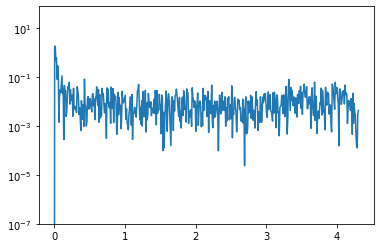

In [84]:
fxx, Pxx = signal.periodogram(x_tt, fs=f_sampling)
plt.semilogy(fxx, Pxx)
plt.ylim(1e-7)

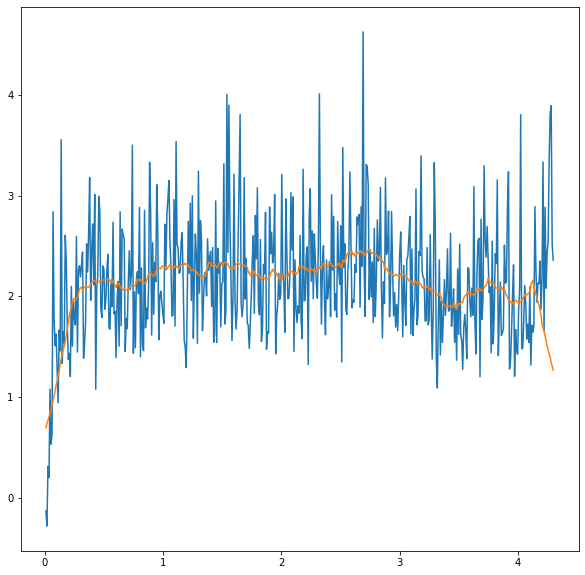

In [123]:
log_psd = -np.log10(Pxx)
size = 20
to_conv = [1/(2*size + 1)] * (2 * size + 1)
clean_psd = np.convolve(log_psd[1:], to_conv)
plt.figure(figsize=(10,10))
plt.plot(fxx[1:], log_psd[1:])
plt.plot(fxx[1:], clean_psd[size:-size])

In [129]:
a = 1e-6

from observer import log_likelihood

def model_ft(pars):
    b, fc1, c = pars
    return -np.log10(b/((1j * fxx + a)**(1/3) * (1j * fxx + fc1)**(c)))

LL = log_likelihood(model_ft, clean_psd[size-1:-size])
pars = optimize.minimize(LL, [1, 0.1, 1/3, 1], method='Nelder-Mead').x

[-0.00810183  0.25189732 -0.16491854  0.23914482]


(1e-07, 80.50021019028229)

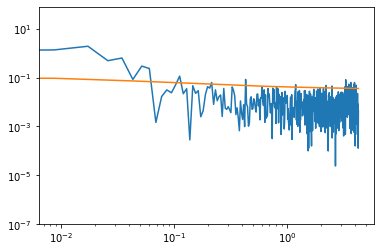

In [131]:
print(pars)
plt.loglog(fxx, Pxx)
plt.loglog(fxx, np.exp(-model_ft(pars[:-1])))
plt.ylim(1e-7)

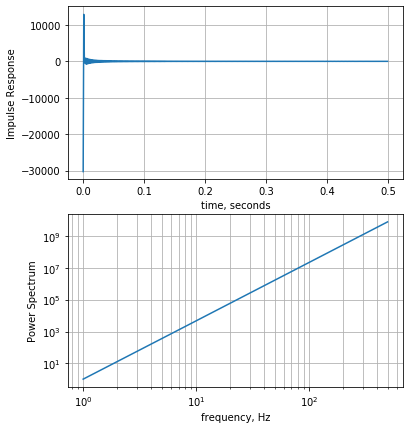

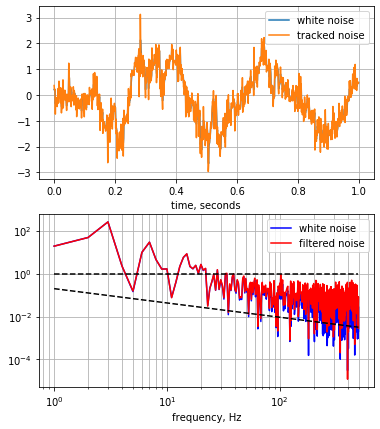

In [13]:
filter_turbulence = design_filt(dt = 1/f_sampling, N = 2*N) 
response = filt(filter_turbulence, dt=1/f_sampling, u=x_tt[:lim])
# I'm worried about overfitting right now, but let's try and ignore that and instead just translate this to SS

In [14]:
def make_impulse_filter(x):
    # takes in np array x: the impulse response of a filter
    # returns matrices A, P, Q, H, R to augment with the kfilter
    n = x.size
    A = np.zeros((n, n))
    for i in range(1, n):
        A[i][i-1] = 1
    A[0] = np.flip(x)
    # when you start the filter, make sure to start it at time n with the first n measurements identically
    P = np.zeros((n,n))
    Q = np.zeros((n,n))
    Q[0][0] = 1
    H = np.zeros((1,n))
    H[:,0] = 1
    R = np.array([0.04**2])
    return A, P, Q, H, R

A, P, Q, H, R = make_impulse_filter(filter_turbulence)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [15]:
# now, let's Kalman filter with this
measurements = x_tt + np.random.normal(0, 0.04, x_tt.shape)
rms = lambda data: np.sqrt(np.mean(data ** 2))
kfiltered = kfilter((measurements[:N], A, P, Q, H, R), measurements[N:lim])

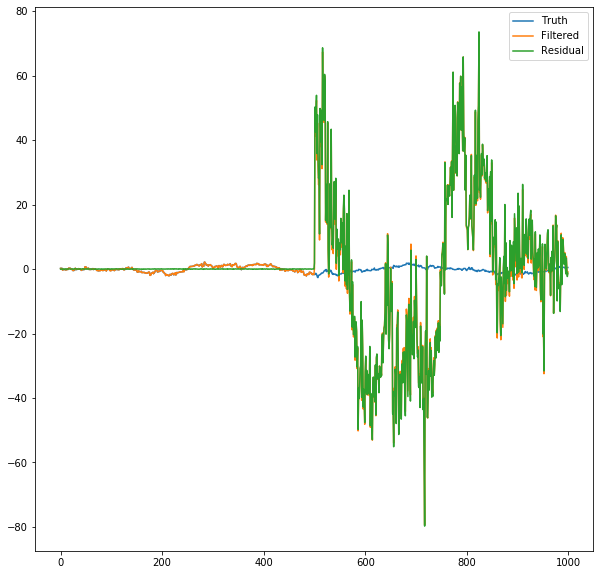

In [16]:
plt.figure(figsize=(10,10))
filtered = np.hstack((measurements[:N], kfiltered))
plt.plot(x_tt[:lim], label='Truth')
plt.plot(filtered, label='Filtered')
residual = filtered - x_tt[:lim]
plt.plot(residual, label='Residual')
plt.legend()

In [17]:
rms(residual[500:])

26.287649194612506

Okay, this is bad - seems like the Kalman filter can't actually get rid of any of the measurement noise.

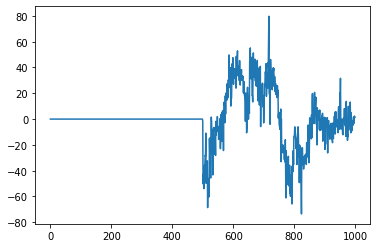

In [18]:
# the 'are you just tracking measurements' plot
plt.plot(measurements[:lim] - filtered[:lim])